#réalisé par : Mohamed Karim HOSNI et Slim El Arbi



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [10]:
def read_dataset(path):
    df = pd.read_csv(path, sep="\t", header=None, names=["date", "price"])
    df['date'] = pd.to_datetime(df['date'], format="%d/%m/%Y")
    df["price"] = df["price"].replace({',' : "."},regex=True).astype(float)
    df = df.set_index(df['date'])
    df.index.names = [None]
    df = df.loc[:,["price"]]
    return df

df_SPX = read_dataset("/content/SPX.txt")
df_USGG2YR = read_dataset("/content/USGG2YR.txt")
df_VIX = read_dataset("/content/VIX.txt")

<Figure size 432x288 with 0 Axes>

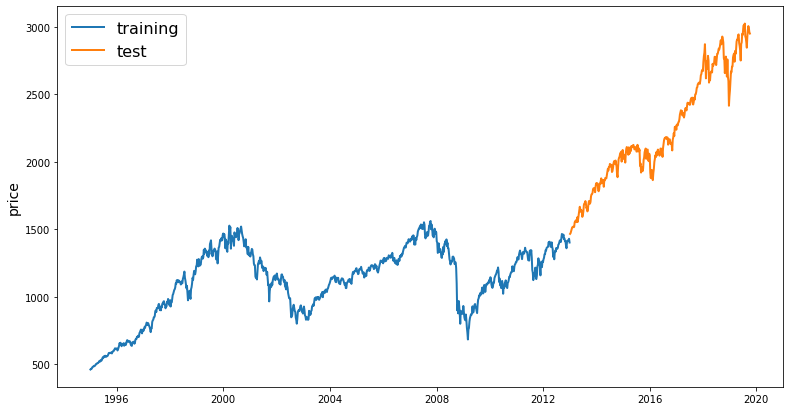

<Figure size 432x288 with 0 Axes>

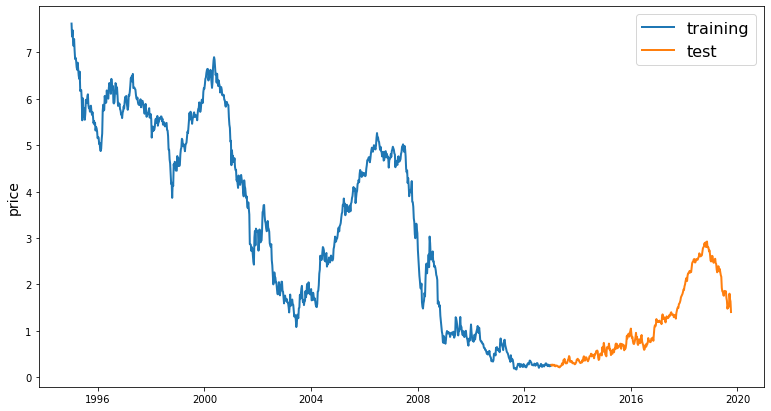

<Figure size 432x288 with 0 Axes>

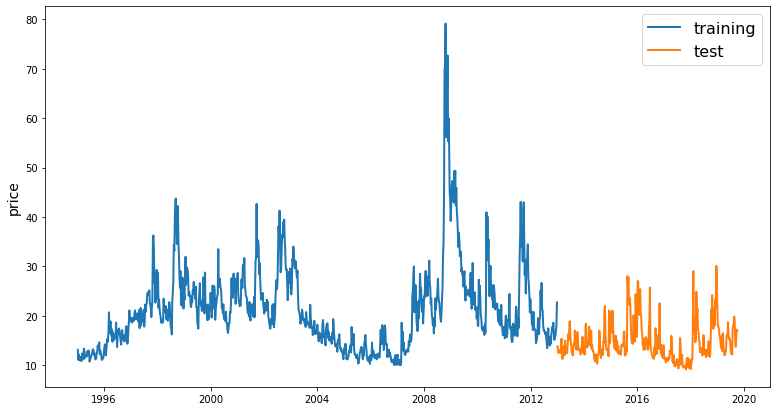

In [11]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (df.max() - df.min())


## Split du dataset par index
def split_dataset(df):
    df_train = df.iloc[0:939]
    df_test = df.iloc[939:]
    
    return df_train, df_test

## Fonction pour créer un interval de "windows_len" a partir du dataset
def extract_window_data(df, window_len=10, normalize=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if normalize:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

## Fonction général pour la création des jeux de train/test et leur normalisation
def prepare_data(df, target_col, window_len=10, normalize=True):
    train_data, test_data = split_dataset(df)
    X_train = extract_window_data(train_data, window_len, normalize)
    X_test = extract_window_data(test_data, window_len, normalize)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if normalize:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

## Fonction de plot de deux datas pour comparer les deux
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    plt.clf()
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)


train_SPX, test_SPX, X_train_SPX, X_test_SPX, y_train_SPX, y_test_SPX = prepare_data(df_SPX, "price", window_len=10)
train_USGG2YR, test_USGG2YR, X_train_USGG2YR, X_test_USGG2YR, y_train_USGG2YR, y_test_USGG2YR = prepare_data(df_USGG2YR, "price", window_len=10)
train_VIX, test_VIX, X_train_VIX, X_test_VIX, y_train_VIX, y_test_VIX = prepare_data(df_VIX, "price", window_len=10)
 
line_plot(train_SPX["price"], test_SPX["price"], 'training', 'test', title='')
plt.show()

line_plot(train_USGG2YR["price"], test_USGG2YR["price"], 'training', 'test', title='')
plt.show()

line_plot(train_VIX["price"], test_VIX["price"], 'training', 'test', title='')
plt.show()

In [12]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, LSTM, Dense, Flatten, Dropout
from keras.models import Model

def create_model(x_train):
    model = keras.Sequential()
    model.add(LSTM(100, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mse', optimizer="adam", metrics=['accuracy'])
    return model

## On crée un modele par indice
model_SPX = create_model(X_train_SPX)
model_USGG2YR = create_model(X_train_USGG2YR)
model_VIX = create_model(X_train_VIX)

In [13]:
model_SPX.fit(X_train_SPX, y_train_SPX, batch_size=16, verbose=0, epochs=10, shuffle=False)
model_USGG2YR.fit(X_train_USGG2YR, y_train_USGG2YR, batch_size=16, verbose=0, epochs=10, shuffle=False)
model_VIX.fit(X_train_VIX, y_train_VIX, batch_size=16, verbose=0, epochs=10, shuffle=False)

In [14]:
targets_SPX = test_SPX["price"][10:]
preds_SPX = model_SPX.predict(X_test_SPX).squeeze()

targets_USGG2YR = test_USGG2YR["price"][10:]
preds_USGG2YR = model_USGG2YR.predict(X_test_USGG2YR).squeeze()

targets_VIX = test_VIX["price"][10:]
preds_VIX = model_VIX.predict(X_test_VIX).squeeze()

<Figure size 432x288 with 0 Axes>

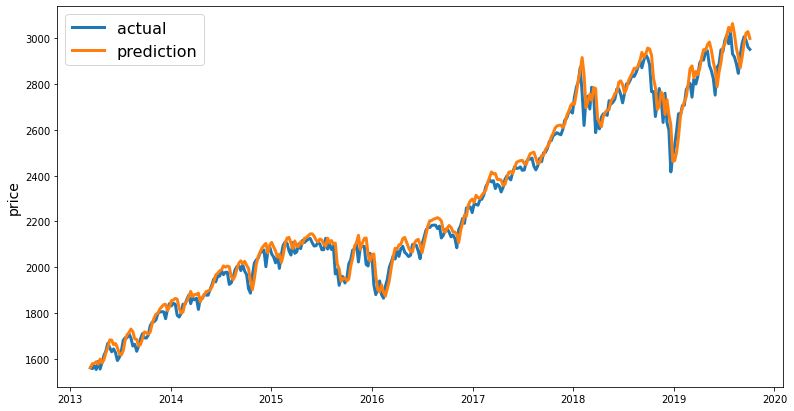

<Figure size 432x288 with 0 Axes>

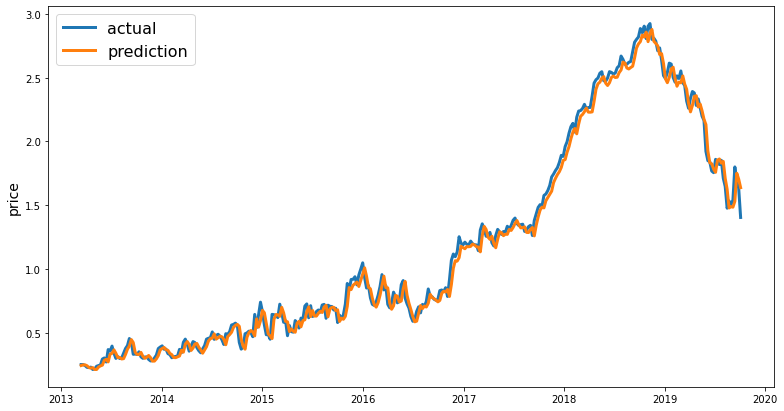

<Figure size 432x288 with 0 Axes>

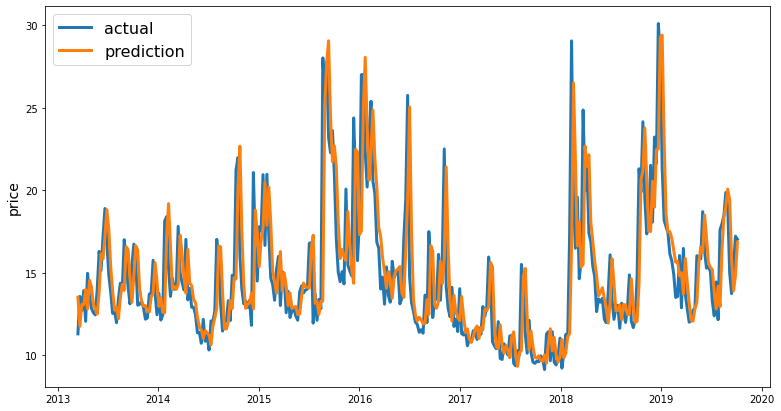

In [15]:
preds_SPX = test_SPX["price"].values[:-10] * (preds_SPX + 1)
preds_SPX = pd.Series(index=targets_SPX.index, data=preds_SPX)
line_plot(targets_SPX, preds_SPX, 'actual', 'prediction', lw=3)
plt.show()

preds_USGG2YR = test_USGG2YR["price"].values[:-10] * (preds_USGG2YR + 1)
preds_USGG2YR = pd.Series(index=targets_USGG2YR.index, data=preds_USGG2YR)
line_plot(targets_USGG2YR, preds_USGG2YR, 'actual', 'prediction', lw=3)
plt.show()

preds_VIX = test_VIX["price"].values[:-10] * (preds_VIX + 1)
preds_VIX = pd.Series(index=targets_VIX.index, data=preds_VIX)
line_plot(targets_VIX, preds_VIX, 'actual', 'prediction', lw=3)
plt.show()

In [17]:
## transformer les prédictions en vecteur 1/0
def generate_direction(preds, test):
    direction = []
    for i in range(len(preds)):
        pred = preds.iloc[i].round(2)
        prev_price = test.iloc[9 + i]["price"]
        if pred > prev_price:
            direction.append(1)
        else:
            direction.append(0)
        
    return direction

direction_SPX = generate_direction(preds_SPX, test_SPX)
direction_USGG2YR = generate_direction(preds_USGG2YR, test_USGG2YR)
direction_VIX = generate_direction(preds_SPX, test_VIX)

## trading: si la somme par période est supérieur a 1: on parie a la hausse sinon on parie la baisse
## A partir de cette logique on calcule le gain sur la période de tests
def trading_model(test_VIX, direction_SPX, direction_USGG2YR, direction_VIX):
    gains = 0
    # Algo a la majorite:
    
    for i in range(9, len(preds_VIX)-1):
            sum_direction = direction_SPX[i-9]
            sum_direction += direction_USGG2YR[i-9]
            sum_direction += direction_VIX[i-9]
            
            prev_value = test_VIX.iloc[i]["price"]
            value = test_VIX.iloc[i+1]["price"]
            # On parie a la hausse
            if sum_direction > 1:
                gains += value - prev_value
            else:
                gains += prev_value - value
                
    
    return gains


def trading_random(test_VIX):
    gains = 0
    for i in range(9, len(preds_VIX)-1):
        prev_value = test_VIX.iloc[i]["price"]
        value = test_VIX.iloc[i+1]["price"]
        choice = random.randint(0, 1)
        if choice == 1:
            gains += value - prev_value
        else:
            gains += prev_value - value
            
    return gains
    

## Calcul des deux gains et affichage
gain_algo = trading_model(test_VIX, direction_SPX, direction_USGG2YR, direction_VIX)
gain_random = trading_random(test_VIX)
print(gain_algo, gain_random)

33.809999999999995 -33.88999999999998


| Gain Model  | Gain Random         |
| :---------------: |:---------------:|
| 20.13  |   -21.44    |